In [1]:
!pip install sentence-transformers

     |████████████████████████████████| 79 kB 6.2 MB/s 
     |████████████████████████████████| 4.0 MB 38.4 MB/s 
     |████████████████████████████████| 1.2 MB 45.7 MB/s 
     |████████████████████████████████| 77 kB 8.4 MB/s 
     |████████████████████████████████| 596 kB 76.7 MB/s 
     |████████████████████████████████| 895 kB 46.3 MB/s 
     |████████████████████████████████| 6.6 MB 63.0 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120747 sha256=716553b31d9b7ddce15b5f74854f9622634e08de3bcf63260a3b2993bd4cf71f
  Stored in directory: /root/.cache/pip/wheels/83/c0/df/b6873ab7aac3f2465aa9144b6b4c41c4391cfecc027c8b07e7
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
!pip install --quiet --user "torch>=1.6, <1.9" "lightning-bolts" "pytorch-lightning>=1.3" "torchmetrics>=0.3" "torchvision" "torchtext" "torchaudio"
! pip install wandb

     |████████████████████████████████| 804.1 MB 2.3 kB/s 
     |████████████████████████████████| 316 kB 89.4 MB/s 
     |████████████████████████████████| 582 kB 87.2 MB/s 
     |████████████████████████████████| 408 kB 61.4 MB/s 
     |████████████████████████████████| 136 kB 70.7 MB/s 
     |████████████████████████████████| 1.1 MB 61.6 MB/s 
     |████████████████████████████████| 21.0 MB 85.9 MB/s 
     |████████████████████████████████| 23.2 MB 1.2 MB/s 
     |████████████████████████████████| 23.3 MB 1.2 MB/s 
     |████████████████████████████████| 23.3 MB 1.2 MB/s 
     |████████████████████████████████| 22.1 MB 1.2 MB/s 
     |████████████████████████████████| 22.1 MB 1.2 MB/s 
     |████████████████████████████████| 17.4 MB 69.0 MB/s 
     |████████████████████████████████| 8.0 MB 41.5 MB/s 
     |████████████████████████████████| 8.0 MB 31.9 MB/s 
     |████████████████████████████████| 8.0 MB 25.5 MB/s 
     |████████████████████████████████| 7.6 MB 52.1 MB/s 
     |█████

In [3]:
!pip install transformers

In [1]:
!curl https://raw.githubusercontent.com/Ojasvi-97/DL_Final_Project_Spring_22/main/train_data.csv --output train.csv
!curl https://raw.githubusercontent.com/Ojasvi-97/DL_Final_Project_Spring_22/main/val_data.csv --output val.csv
!curl https://raw.githubusercontent.com/Ojasvi-97/DL_Final_Project_Spring_22/main/test_data.csv --output test.csv


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 11.0M  100 11.0M    0     0  15.0M      0 --:--:-- --:--:-- --:--:-- 15.0M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3944k  100 3944k    0     0  6508k      0 --:--:-- --:--:-- --:--:-- 6508k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4199k  100 4199k    0     0  8915k      0 --:--:-- --:--:-- --:--:-- 8915k


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:

# !unzip gdrive/My\ Drive/Colab\ Notebooks/visual_embeddings_final.zip > /dev/null

In [3]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [4]:
import os
import pandas as pd
import random
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.utils import shuffle


from transformers import BertTokenizer, BertModel
from transformers import BertModel
from sentence_transformers import SentenceTransformer

import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

import torch.nn as nn


import pytorch_lightning as pl
from pytorch_lightning import LightningModule, Trainer, seed_everything
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.loggers import WandbLogger
from torch.optim.lr_scheduler import ReduceLROnPlateau
import math

seed_everything(7)
NUM_WORKERS = int(os.cpu_count() - 1)
AVAIL_GPUS = min(1, torch.cuda.device_count())
# BATCH_SIZE = 256 if AVAIL_GPUS else 64
BATCH_SIZE = 128
print(AVAIL_GPUS, BATCH_SIZE, NUM_WORKERS)

Global seed set to 7


1 128 3


In [5]:
class HMDataset(Dataset):
    def __init__(self, data):
        self.df = data
        self.tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
        self.max_length = 100
        # preprocess function for text


      # self.tokenizer(pos_data["detail_desc"], max_length=self.max_length, padding='max_length', truncation=True)
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        
        ref_data = self.df.iloc[idx]
        ref_text = ref_data["detail_desc"]
        ref_inputs = self.tokenizer.encode_plus(
                                          ref_text,
                                          None,
                                          pad_to_max_length=True,
                                          add_special_tokens=True,
                                          return_attention_mask=True,
                                          max_length=self.max_length,
                                          truncation=True
                                          )
        ref_ids = ref_inputs["input_ids"]
        ref_token_type_ids = ref_inputs["token_type_ids"]
        ref_mask = ref_inputs["attention_mask"]
        ref_label = ref_data["index_group_name"]
        art_id = ref_data["article_id"]
        

        pos_data = pd.DataFrame(self.df[self.df["index_group_name"] == ref_data["index_group_name"]].sample(n=1))
        pos_data = pos_data.iloc[0]
        pos_text = pos_data["detail_desc"]
        pos_inputs = self.tokenizer.encode_plus(
                                          pos_text,
                                          None,
                                          pad_to_max_length=True,
                                          add_special_tokens=True,
                                          return_attention_mask=True,
                                          max_length=self.max_length,
                                          truncation=True
                                          )
        pos_ids = pos_inputs["input_ids"]
        pos_token_type_ids = pos_inputs["token_type_ids"]
        pos_mask = pos_inputs["attention_mask"]
        pos_label = pos_data["index_group_name"]
        
        neg_data = pd.DataFrame(self.df[self.df["index_group_name"] != ref_data["index_group_name"]].sample(n=1))
        neg_data = neg_data.iloc[0]
        neg_text =  neg_data["detail_desc"]
        neg_inputs = self.tokenizer.encode_plus(
                                          neg_text,
                                          None,
                                          pad_to_max_length=True,
                                          add_special_tokens=True,
                                          return_attention_mask=True,
                                          max_length=self.max_length,
                                          truncation=True
                                          )
        neg_ids = neg_inputs["input_ids"]
        neg_token_type_ids = neg_inputs["token_type_ids"]
        neg_mask = neg_inputs["attention_mask"]
        neg_label = neg_data["index_group_name"]
        
        attributes = {
            "ref_ids": torch.tensor(ref_ids, dtype=torch.long),
            "pos_ids": torch.tensor(pos_ids, dtype=torch.long),
            "neg_ids": torch.tensor(neg_ids, dtype=torch.long),
            "ref_mask": torch.tensor(ref_mask, dtype=torch.long),
            "pos_mask": torch.tensor(pos_mask, dtype=torch.long),
            "neg_mask": torch.tensor(neg_mask, dtype=torch.long),
            "ref_token_ids": torch.tensor(ref_token_type_ids, dtype=torch.long),
            "pos_token_ids": torch.tensor(pos_token_type_ids, dtype=torch.long),
            "neg_token_ids": torch.tensor(neg_token_type_ids, dtype=torch.long),
            "ref_label": ref_label,
            "ref_article_id": art_id
        }
        
        return attributes

In [6]:
class HMDataModule(pl.LightningDataModule):
    def __init__(self, train_path="", val_path="", batch_size= BATCH_SIZE):
        super().__init__()
        self.batch_size = batch_size
        
        #data 
        self.train_df, self.val_df= pd.read_csv(train_path), shuffle(pd.read_csv(val_path))
        

    def setup(self, stage=None):
        self.train_data = HMDataset(data=self.train_df)
        self.val_data = HMDataset(data=self.val_df)
        

    def train_dataloader(self):
        return DataLoader(self.train_data, batch_size=self.batch_size, shuffle=True, num_workers=NUM_WORKERS)

    def val_dataloader(self):
        return DataLoader(self.val_data, batch_size=self.batch_size, num_workers=NUM_WORKERS)

    

In [7]:
class TextEmbd(nn.Module):
    # resnet last 2 layers
    # dense layers
    # similarity
    def __init__(self):
        super().__init__()
        self.model = BertModel.from_pretrained("prajjwal1/bert-medium")
        self.model.train()
        self.af = nn.ReLU()
        self.last_layer = nn.Linear(512, 256)

        for param in self.model.parameters():
          param.requires_grad = False

        for idx, submodule in enumerate(self.model.children()):
          if idx == 1:
            for id_child, child in enumerate(submodule.children()):
              for id_subchild, subchild in enumerate(child.children()): 
                  if id_subchild > 3:
                    for param in subchild.parameters():
                      param.requires_grad = True

          if idx == 2:
            for param in submodule.parameters():
              param.requires_grad = True

          
    
    def forward(self,ids,mask,token_type_ids):
        _, x = self.model(ids,attention_mask=mask,token_type_ids=token_type_ids, return_dict=False)
        x = self.last_layer(self.af(x))
        return x

In [6]:

# m = TextEmbd()

# total_params = sum(p.numel() for p in m.parameters() if p.requires_grad)
# print(total_params)

In [8]:
class LitTextEmbd(LightningModule):
    def __init__(self, lr=0.001, margin=0.1):
        super().__init__()
        self.save_hyperparameters()
        self.model = TextEmbd()
        self.margin = margin
        self.learning_rate = lr
        self.pca = PCA(n_components=50)
        self.tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
        
    def forward(self, ids, mask, token_type_ids):
        x = self.model(ids, mask, token_type_ids)
        return x
    
    def training_step(self, batch, batch_idx):
        return self.evaluate(batch, batch_idx, stage="train")

    def log_plot(self, embds, labels):

        df_subset = pd.DataFrame()

        pca_embd = self.pca.fit_transform(embds.cpu().detach().numpy())
        print('Cumulative explained variation for 50 principal components: {}'.format(np.sum(self.pca.explained_variance_ratio_)))
        tsne_pca_results = self.tsne.fit_transform(pca_embd)

        
        df_subset['tsne-pca50-one'] = tsne_pca_results[:,0]
        df_subset['tsne-pca50-two'] = tsne_pca_results[:,1]

        df_subset["label"] = labels

        sns.scatterplot(
          x="tsne-pca50-one", y="tsne-pca50-two",
          hue="label",
          palette=sns.color_palette("hls", len(set(labels))),
          data=df_subset,
          legend="full",
          alpha=0.3)
        
        self.logger.experiment.log({"t-sne plot": plt})

        plt.close()
    
    def evaluate(self, batch, batch_idx, stage=None):


        ref_embd = self(batch["ref_ids"], batch["ref_mask"], batch["ref_token_ids"])
        pos_embd = self(batch["pos_ids"], batch["pos_mask"], batch["pos_token_ids"])
        neg_embd = self(batch["neg_ids"], batch["neg_mask"], batch["neg_token_ids"])
        
        # pos_sim = cosine_similarity(ref_embd, pos_embd)
        # neg_sim = cosine_similarity(ref_embd, neg_embd)
        
        # pos_distance = torch.linalg.norm(ref_embd, pos_embd, dim=-1)
        # neg_distance = torch.linalg.norm(ref_embd, pos_embd, dim=-1)
        # loss = torch.relu(math.pow(pos_distance,2) - math.pow(neg_distance,2) + self.margin)

        tml = torch.nn.TripletMarginLoss(margin=self.margin, p=2)
        loss = tml(ref_embd, pos_embd, neg_embd)
        
        if stage:
            self.log(f"{stage}_loss", loss.mean(), prog_bar=True)

            if batch_idx == 0:
              self.log_plot(ref_embd, batch["ref_label"])

        return loss.mean()

    def validation_step(self, batch, batch_idx):
        self.evaluate(batch, batch_idx, "val")

    
    def configure_optimizers(self):
        optimizer = torch.optim.SGD(
            self.parameters(),
            lr=self.learning_rate,
            momentum=0.9,
            weight_decay=5e-4)
        
        scheduler = ReduceLROnPlateau(optimizer, 'min')
#         steps_per_epoch = 40000 // BATCH_SIZE
        return {"optimizer": optimizer, "scheduler": scheduler}

        


In [8]:
hm_dm = HMDataModule(
    train_path="train.csv",
    val_path = "val.csv")

In [9]:
model = LitTextEmbd()
model.datamodule = hm_dm

# trainer = Trainer(
#           progress_bar_refresh_rate=10,
#           gpus=AVAIL_GPUS,
#           max_epochs=10,
#           logger=WandbLogger(project="final_project_text"),
#           callbacks=[LearningRateMonitor(logging_interval="step")]
#       )

# trainer.fit(model, hm_dm)

Some weights of the model checkpoint at prajjwal1/bert-medium were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


/root/.local/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:97: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=10)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/.local/lib/python3.7/site-packages/pytorch_lightning/core/optimizer.py:381: RuntimeWarning: Found unsupported keys in the optimizer configuration: {'scheduler'}
  f"Found unsupported keys in the optimizer configuration: {set(extra_keys)}", categ

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Cumulative explained variation for 50 principal components: 0.9549583792686462


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:575: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:613: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning:

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning:

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the mode

Cumulative explained variation for 50 principal components: 0.9293244481086731


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:575: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:613: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning:

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning:

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the mode

Cumulative explained variation for 50 principal components: 0.9747384786605835


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:575: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:613: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/root/.local/lib/python3.7/site-packages/pytorch_lightning/utilities/data.py:73: UserWarning:

Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 104. To avoid any miscalculations, use `self.log(..., batch_size=b

Cumulative explained variation for 50 principal components: 0.9342899322509766


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:575: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:613: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning:

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning:

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the mode

Cumulative explained variation for 50 principal components: 0.9813936948776245


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:575: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:613: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning:

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longes

Cumulative explained variation for 50 principal components: 0.9453992247581482


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:575: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:613: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning:

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning:

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the mode

Cumulative explained variation for 50 principal components: 0.9842512011528015


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:575: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:613: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning:

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longes

Cumulative explained variation for 50 principal components: 0.9552497267723083


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:575: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:613: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning:

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning:

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the mode

Cumulative explained variation for 50 principal components: 0.9862040281295776


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:575: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:613: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning:

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longes

Cumulative explained variation for 50 principal components: 0.9599263072013855


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:575: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:613: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning:

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning:

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the mode

Cumulative explained variation for 50 principal components: 0.9849205017089844


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:575: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:613: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning:

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longes

Cumulative explained variation for 50 principal components: 0.9591299295425415


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:575: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:613: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning:

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning:

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the mode

Cumulative explained variation for 50 principal components: 0.9866700768470764


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:575: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:613: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning:

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longes

Cumulative explained variation for 50 principal components: 0.9639233350753784


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:575: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:613: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning:

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning:

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the mode

Cumulative explained variation for 50 principal components: 0.9881566762924194


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:575: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:613: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning:

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longes

Cumulative explained variation for 50 principal components: 0.9686955809593201


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:575: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:613: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning:

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning:

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the mode

Cumulative explained variation for 50 principal components: 0.9880427718162537


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:575: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:613: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning:

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longes

Cumulative explained variation for 50 principal components: 0.9717579483985901


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:575: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:613: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning:

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning:

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the mode

Cumulative explained variation for 50 principal components: 0.9889018535614014


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:575: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:613: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning:

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longes

Cumulative explained variation for 50 principal components: 0.972201406955719


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:575: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:613: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning:

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning:

The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the mode

Cumulative explained variation for 50 principal components: 0.989273726940155


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:575: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/usr/local/lib/python3.7/dist-packages/plotly/matplotlylib/renderer.py:613: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



In [10]:
# model_save_name = 'text_triplet'
# path = F"/content/gdrive/My Drive/{model_save_name}" 
# torch.save(model.state_dict(), path)

Testing the model

In [9]:
model = LitTextEmbd()

model_save_name = 'text_triplet'
path = F"/content/gdrive/My Drive/{model_save_name}"
model.load_state_dict(torch.load(path))

Downloading:   0%|          | 0.00/286 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/159M [00:00<?, ?B/s]

Some weights of the model checkpoint at prajjwal1/bert-medium were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

In [16]:
from tqdm import tqdm 

def test_plot(embds, labels, tag=""):
      pca = PCA(n_components=10)
      tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)

      df_subset = pd.DataFrame()

      pca_embd = pca.fit_transform(embds)
      print('Cumulative explained variation for 50 principal components: {}'.format(np.sum(pca.explained_variance_ratio_)))
      tsne_pca_results = tsne.fit_transform(pca_embd)

      
      df_subset['tsne-pca50-one'] = tsne_pca_results[:,0]
      df_subset['tsne-pca50-two'] = tsne_pca_results[:,1]

      df_subset["label"] = labels



      sns.scatterplot(
        x="tsne-pca50-one", y="tsne-pca50-two",
        hue="label",
        palette=sns.color_palette("hls", len(set(labels))),
        data=df_subset,
        legend="full",
        alpha=0.3)
      
      plt.savefig('text_embd_'+tag+'.jpg')
      plt.show()
      plt.close()



def inference(test_loader, model, tag=""):
  all_embds = []
  all_labels = []
  all_article_ids = []

  model.eval()

  for x in tqdm(test_loader):
    final_embds = model(x["ref_ids"], x["ref_mask"], x["ref_token_ids"])
    all_embds.append(final_embds.cpu().detach().numpy())

    all_labels.extend(x["ref_label"])
    all_article_ids.extend(x["ref_article_id"])

  all_embs_con = np.concatenate(all_embds, axis=0)

  print("Plotting...")
  test_plot(all_embs_con, all_labels, tag)

  return [all_embs_con, all_article_ids]


Generating embeddings for  test.csv


  0%|          | 0/177 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length

Plotting...
Cumulative explained variation for 50 principal components: 0.8442034125328064


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


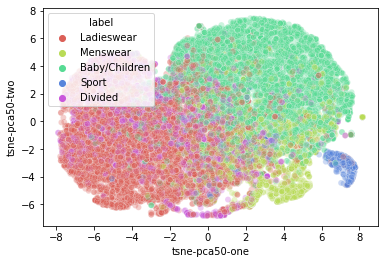

Generating embeddings for  train.csv


  0%|          | 0/476 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length

Plotting...
Cumulative explained variation for 50 principal components: 0.8438947200775146


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


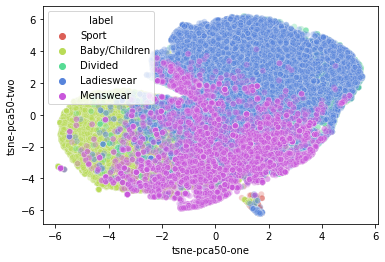

Generating embeddings for  val.csv


  0%|          | 0/166 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length

Plotting...
Cumulative explained variation for 50 principal components: 0.845011293888092


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


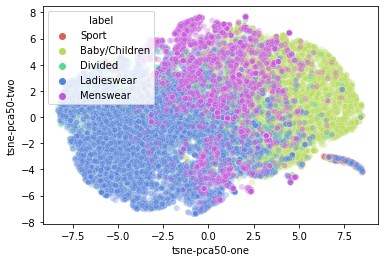

In [17]:
inference_paths = ["test.csv", "train.csv", "val.csv"]


path_embds = []

for path in inference_paths:
  print("Generating embeddings for ", path)

  test_df = pd.read_csv(path)
  test_data = HMDataset(data=test_df)
  test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
  
  test_embds = inference(test_loader, model, tag=path[:-4])
  path_embds.append(test_embds)

In [18]:
def convert_to_dataframe(embds):
  df_embd = pd.DataFrame()

  for i in range(embds[0].shape[1]):
    df_embd["feature_" + str(i)] = embds[0][:, i]
  
  df_embd["article_id"] = embds[1]
  df_embd["article_id"] = df_embd["article_id"].apply(lambda x: x.item())

  return df_embd


In [19]:
test_embds_df = convert_to_dataframe(path_embds[0])
train_embds_df = convert_to_dataframe(path_embds[1])
val_embds_df = convert_to_dataframe(path_embds[2])
final_embds = pd.concat([test_embds_df, train_embds_df, val_embds_df], ignore_index=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  import sys


In [20]:
final_embds.shape

(104695, 257)

In [21]:
final_embds.to_csv("text_embeddings_final.csv")